<a href="https://colab.research.google.com/github/Avd-softer/uber-trip-analysis/blob/main/Uber_Trip_Analysis_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error







In [3]:
# 1. DATA LOADING & MERGING
# Combining multiple monthly CSV files into one dataframe
files = [
    'uber-raw-data-apr14.csv', 'uber-raw-data-may14.csv', 'uber-raw-data-jun14.csv',
    'uber-raw-data-janjune-15.csv','uber-raw-data-jul14.csv', 'uber-raw-data-aug14.csv', 'uber-raw-data-sep14.csv'
]

df_list = []
for file in files:
    try:
        temp_df = pd.read_csv(file)
        df_list.append(temp_df)
    except FileNotFoundError:
        print(f"File {file} not found, skipping.")

df = pd.concat(df_list, ignore_index=True)


In [4]:
# 2. DATA PREPROCESSING
# Converting Date/Time to datetime objects
df['Date/Time'] = pd.to_datetime(df['Date/Time'])

# Extracting temporal features
df['Day'] = df['Date/Time'].dt.day
df['Weekday'] = df['Date/Time'].dt.day_name()
df['Hour'] = df['Date/Time'].dt.hour
df['Month'] = df['Date/Time'].dt.month


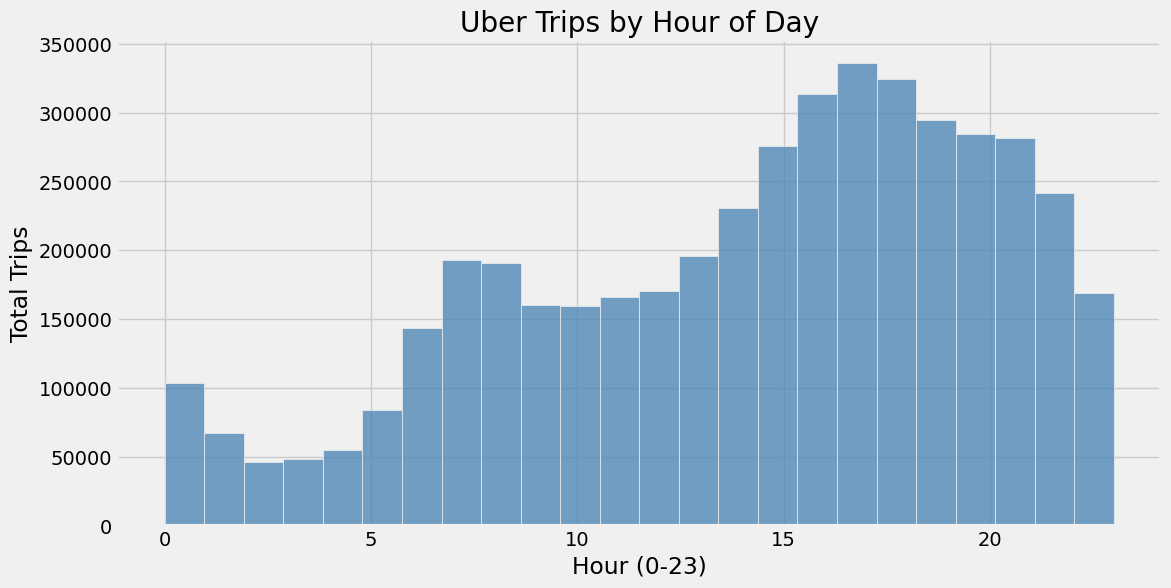

/tmp/ipython-input-3364704511.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Weekday', data=df, order=order, palette='viridis')


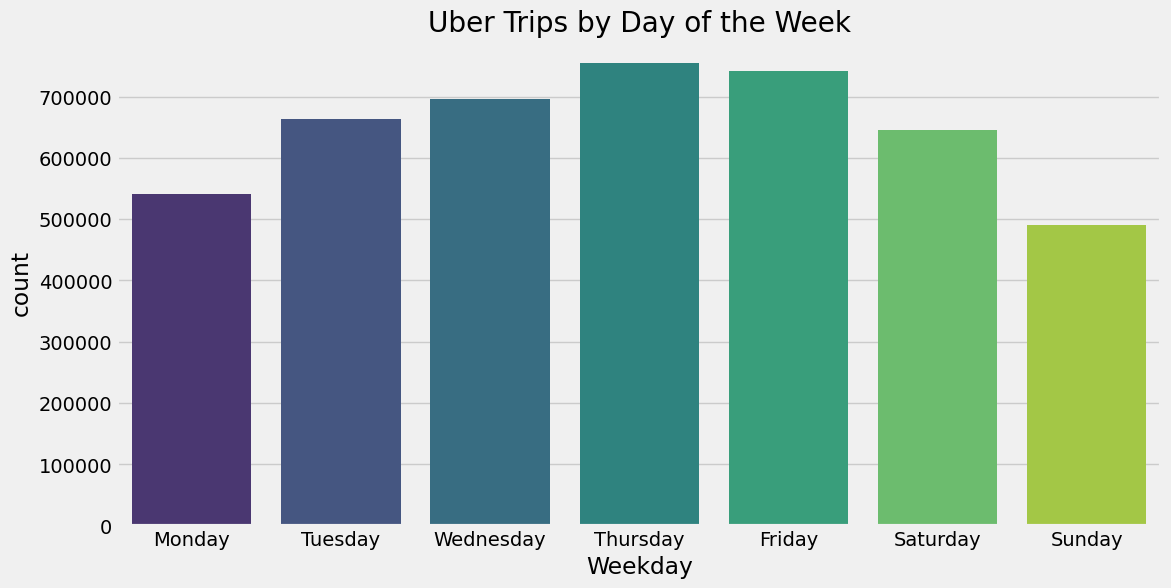

/tmp/ipython-input-3364704511.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Month', data=df, palette='magma')


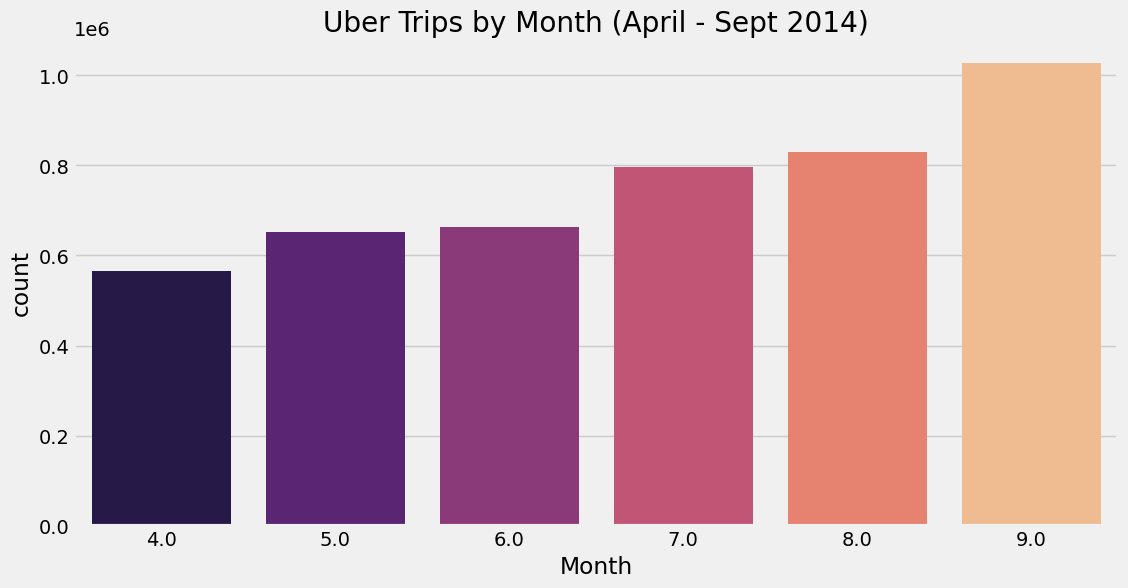

In [5]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)
plt.style.use('fivethirtyeight')

# A. Analysis by Hour
plt.figure(figsize=(12, 6))
sns.histplot(df['Hour'], bins=24, color='steelblue')
plt.title('Uber Trips by Hour of Day')
plt.xlabel('Hour (0-23)')
plt.ylabel('Total Trips')
plt.show()

# B. Analysis by Day of Week
plt.figure(figsize=(12, 6))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='Weekday', data=df, order=order, palette='viridis')
plt.title('Uber Trips by Day of the Week')
plt.show()

# C. Analysis by Month
plt.figure(figsize=(12, 6))
sns.countplot(x='Month', data=df, palette='magma')
plt.title('Uber Trips by Month (April - Sept 2014)')
plt.show()

Model Results:
MAPE: 0.1354
RMSE: 166.18


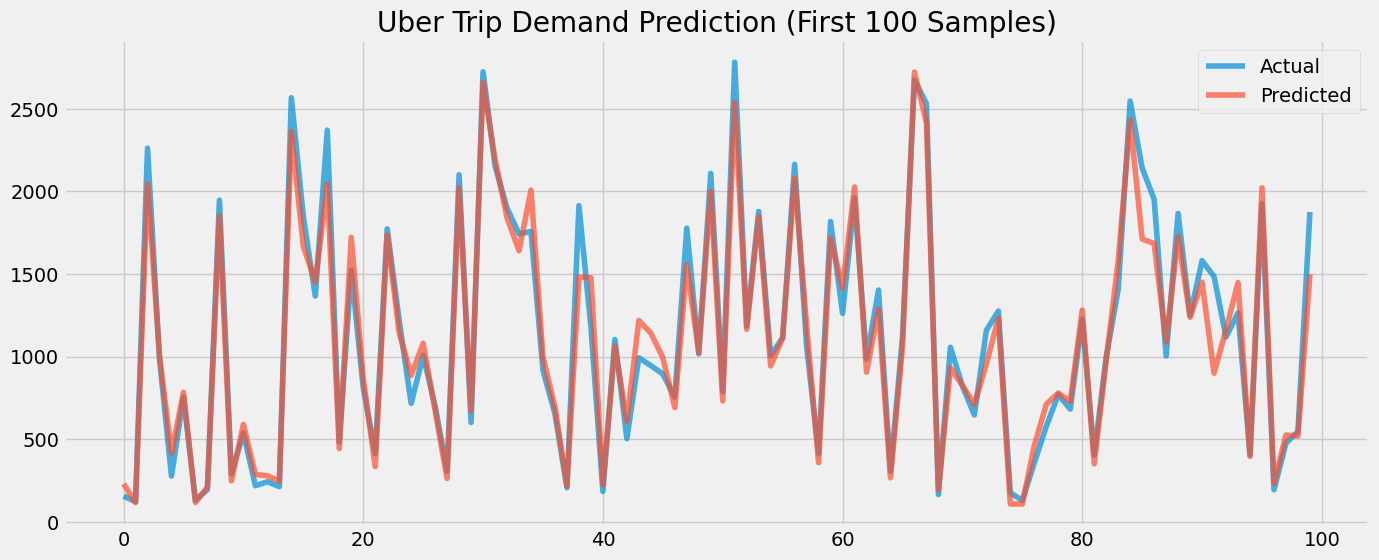

In [6]:
# 4. MACHINE LEARNING: DEMAND PREDICTION (XGBOOST)
# For prediction, we aggregate trips per hour per day
prediction_df = df.groupby(['Month', 'Day', 'Hour', 'Weekday']).size().reset_index(name='TripCount')

# Encoding Weekday for the model
prediction_df['Weekday_Num'] = pd.to_datetime(
    prediction_df[['Month', 'Day']].assign(Year=2014).rename(columns={'Month':'month', 'Day':'day'})
).dt.weekday

# Define Features and Target
X = prediction_df[['Month', 'Day', 'Hour', 'Weekday_Num']]
y = prediction_df['TripCount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training XGBoost Regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Model Results:")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.2f}")

# Visualizing Predictions vs Actual
plt.figure(figsize=(15, 6))
plt.plot(y_test.values[:100], label='Actual', alpha=0.7)
plt.plot(y_pred[:100], label='Predicted', alpha=0.7)
plt.title('Uber Trip Demand Prediction (First 100 Samples)')
plt.legend()
plt.show()